In [1]:
# 📌 1. Imports and Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import pytz
from scipy.spatial import ConvexHull
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# For Model 2: pvlib (alternative to pysolar)
!pip install pvlib
import pvlib

In [3]:
# For Model 3: pybdshadow (optional, for geospatial shadow analysis)
#!pip install pybdshadow #geopandas suncalc-py keplergl
#import pybdshadow

# 📌 2. Constants and Parameters
LATITUDE = 29.8375
LONGITUDE = 80.0316
ROOF_TILT_DEG = 30
ROOF_AZIMUTH_DEG = 135  # Southeast-facing
CHIMNEY_HEIGHT = 1.0  # meters
CHIMNEY_BASE = 1.0    # meters (square)
TIMEZONE = pytz.timezone('Asia/Kolkata')

In [4]:
# 📌 3. Helper Functions for Solar Geometry and Projections

def get_sun_vector_pysolar(dt):
    """Get sun vector using pysolar for a given datetime."""
    from pysolar.solar import get_altitude, get_azimuth
    dt_utc = dt.astimezone(pytz.utc)
    elev = get_altitude(LATITUDE, LONGITUDE, dt_utc)
    azim = get_azimuth(LATITUDE, LONGITUDE, dt_utc)
    if elev <= 0:
        return None
    elev_rad = np.radians(elev)
    azim_rad = np.radians(azim)
    sx = np.sin(azim_rad) * np.cos(elev_rad)
    sy = np.cos(azim_rad) * np.cos(elev_rad)
    sz = np.sin(elev_rad)
    return np.array([sx, sy, sz])

def get_sun_vector_pvlib(dt):
    """Get sun vector using pvlib for a given datetime."""
    times = pd.DatetimeIndex([dt.astimezone(pytz.utc)])
    solpos = pvlib.solarposition.get_solarposition(
        times, LATITUDE, LONGITUDE
    ).iloc[0]
    elev = solpos['apparent_elevation']
    azim = solpos['azimuth']
    if elev <= 0:
        return None
    elev_rad = np.radians(elev)
    azim_rad = np.radians(azim)
    sx = np.sin(azim_rad) * np.cos(elev_rad)
    sy = np.cos(azim_rad) * np.cos(elev_rad)
    sz = np.sin(elev_rad)
    return np.array([sx, sy, sz])

def get_roof_normal():
    """Return the normal vector of the tilted roof."""
    tilt_rad = np.radians(ROOF_TILT_DEG)
    az_rad = np.radians(ROOF_AZIMUTH_DEG)
    nx = -np.sin(tilt_rad) * np.sin(az_rad)
    ny = -np.sin(tilt_rad) * np.cos(az_rad)
    nz = np.cos(tilt_rad)
    return np.array([nx, ny, nz])

def get_chimney_corners():
    """Return 3D coordinates of the chimney's top corners."""
    d = CHIMNEY_BASE / 2
    return [
        np.array([d, d, CHIMNEY_HEIGHT]),
        np.array([-d, d, CHIMNEY_HEIGHT]),
        np.array([-d, -d, CHIMNEY_HEIGHT]),
        np.array([d, -d, CHIMNEY_HEIGHT])
    ]

def project_point_to_plane(point, vector, normal):
    """Project a point along a vector onto a plane defined by its normal."""
    dot = np.dot(normal, vector)
    if abs(dot) < 1e-6:
        return None
    t = -np.dot(normal, point) / dot
    return point + t * vector

def convert_to_roof_plane_coords(points_3d, normal):
    """Convert 3D points to 2D coordinates in the roof's local plane."""
    u = np.cross([0, 0, 1], normal)
    if np.linalg.norm(u) == 0:
        u = np.array([1, 0, 0])
    u = u / np.linalg.norm(u)
    v = np.cross(normal, u)
    coords_2d = []
    for p in points_3d:
        x = np.dot(p, u)
        y = np.dot(p, v)
        coords_2d.append([x, y])
    return np.array(coords_2d)

def polygon_area(points):
    """Calculate area of a polygon given its vertices."""
    if len(points) < 3:
        return 0.0
    x = points[:, 0]
    y = points[:, 1]
    return 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))

# 📌 4. Main Shadow Area Calculation - Model Comparison

def calculate_shadow_area(dt, sun_model="pysolar", visualize=True):
    """Calculate shadow area using the selected sun position model."""
    if sun_model == "pysolar":
        sun_vec = get_sun_vector_pysolar(dt)
    elif sun_model == "pvlib":
        sun_vec = get_sun_vector_pvlib(dt)
    else:
        raise ValueError("Unknown sun_model")
    if sun_vec is None:
        return 0.0, None
    roof_normal = get_roof_normal()
    chimney_top = get_chimney_corners()
    shadow_pts = []
    for corner in chimney_top:
        proj = project_point_to_plane(corner, sun_vec, roof_normal)
        if proj is not None:
            shadow_pts.append(proj)
    if len(shadow_pts) < 3:
        return 0.0, None
    coords_2d = convert_to_roof_plane_coords(shadow_pts, roof_normal)
    hull = ConvexHull(coords_2d)
    shadow_poly = coords_2d[hull.vertices]
    area = polygon_area(shadow_poly)
    if visualize:
        plt.figure(figsize=(6, 6))
        plt.fill(shadow_poly[:, 0], shadow_poly[:, 1], alpha=0.5, label=f"Shadow ({sun_model})")
        plt.scatter(0, 0, color='red', label='Chimney Center')
        plt.title(f"Shadow Polygon on Roof Plane ({sun_model})")
        plt.xlabel("Roof X (m)")
        plt.ylabel("Roof Y (m)")
        plt.axis('equal')
        plt.grid(True)
        plt.legend()
        plt.show()
    return area, shadow_poly

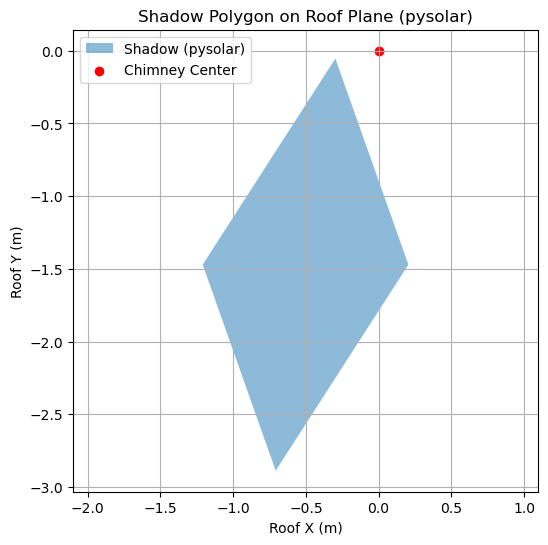

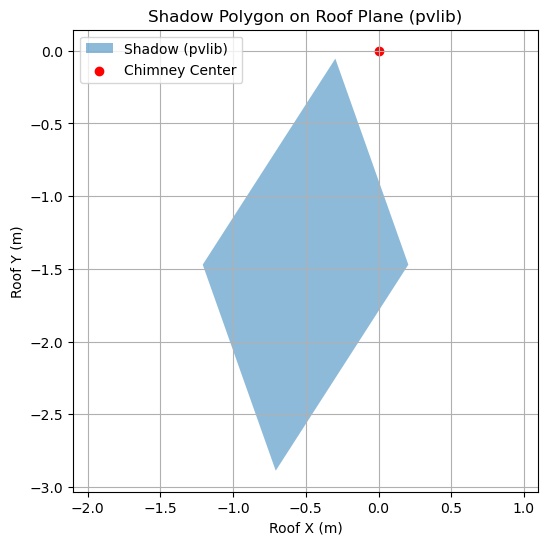

Shadow area (pysolar) on 2022-10-08 11:00:00+05:30: 2.0038 m²
Shadow area (pvlib) on 2022-10-08 11:00:00+05:30: 2.0042 m²


In [5]:
# 📌 5. Example Calculation and Model Comparison

example_dt = TIMEZONE.localize(datetime(2022, 10, 8, 11, 0))
area_pysolar, _ = calculate_shadow_area(example_dt, sun_model="pysolar")
area_pvlib, _ = calculate_shadow_area(example_dt, sun_model="pvlib")
print(f"Shadow area (pysolar) on {example_dt}: {area_pysolar:.4f} m²")
print(f"Shadow area (pvlib) on {example_dt}: {area_pvlib:.4f} m²")

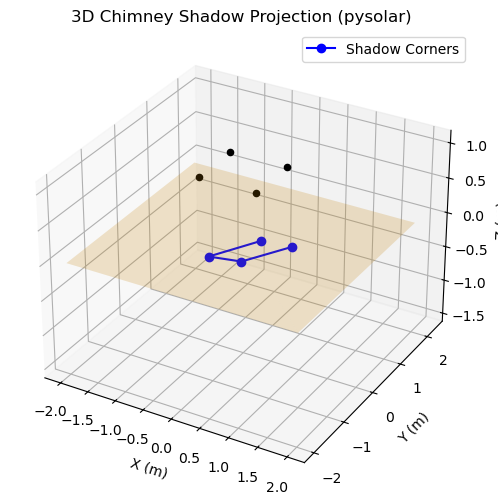

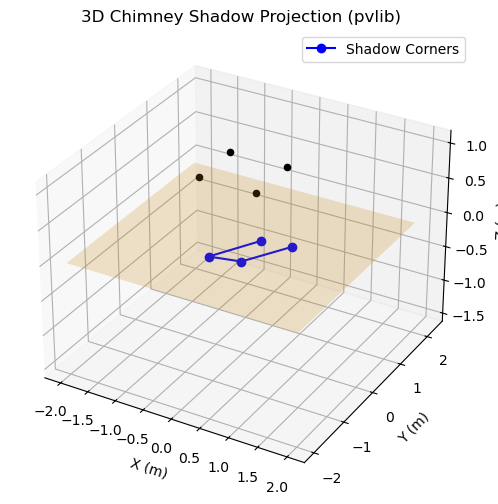

In [6]:
# 📌 6. 3D Visualization for Enhanced Interactivity

def plot_3d_shadow(dt, sun_model="pysolar"):
    """Plot 3D view of the chimney, roof, and shadow projection."""
    if sun_model == "pysolar":
        sun_vec = get_sun_vector_pysolar(dt)
    else:
        sun_vec = get_sun_vector_pvlib(dt)
    roof_normal = get_roof_normal()
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    # Plot chimney
    corners = get_chimney_corners()
    for corner in corners:
        ax.scatter(*corner, color='k')
    # Plot projected shadow
    shadow_pts = []
    for corner in corners:
        proj = project_point_to_plane(corner, sun_vec, roof_normal)
        if proj is not None:
            shadow_pts.append(proj)
    shadow_pts = np.array(shadow_pts)
    if len(shadow_pts) > 0:
        ax.plot(shadow_pts[:, 0], shadow_pts[:, 1], shadow_pts[:, 2], 'bo-', label="Shadow Corners")
    # Plot roof plane (as a patch)
    d = 2
    roof_pts = np.array([
        [d, d, 0],
        [-d, d, 0],
        [-d, -d, 0],
        [d, -d, 0]
    ])
    ax.plot_trisurf(roof_pts[:, 0], roof_pts[:, 1], roof_pts[:, 2], alpha=0.2, color='orange')
    ax.set_title(f"3D Chimney Shadow Projection ({sun_model})")
    ax.set_xlabel("X (m)")
    ax.set_ylabel("Y (m)")
    ax.set_zlabel("Z (m)")
    plt.legend()
    plt.show()

plot_3d_shadow(example_dt, sun_model="pysolar")
plot_3d_shadow(example_dt, sun_model="pvlib")

In [7]:
# 📌 8. Model Comparison Summary
print("Model Comparison:")
print(f"Pysolar area: {area_pysolar:.4f} m²")
print(f"pvlib area:   {area_pvlib:.4f} m²")

Model Comparison:
Pysolar area: 2.0038 m²
pvlib area:   2.0042 m²


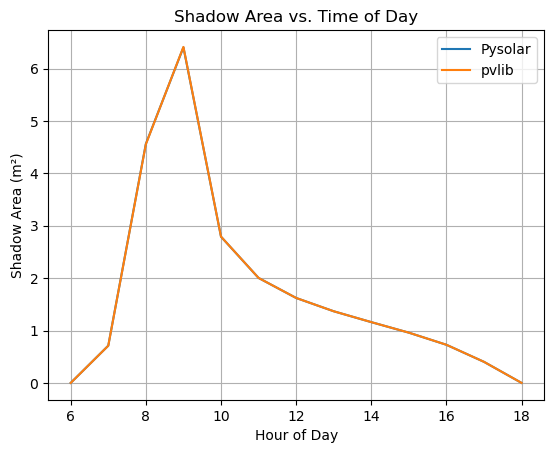

In [8]:
# 📌 9. Additional Interactivity: Shadow Area Throughout the Day
import pandas as pd
times = [TIMEZONE.localize(datetime(2022, 10, 8, h, 0)) for h in range(6, 19)]
areas_pysolar = [calculate_shadow_area(dt, sun_model="pysolar", visualize=False)[0] for dt in times]
areas_pvlib = [calculate_shadow_area(dt, sun_model="pvlib", visualize=False)[0] for dt in times]
plt.plot([dt.hour for dt in times], areas_pysolar, label="Pysolar")
plt.plot([dt.hour for dt in times], areas_pvlib, label="pvlib")
plt.xlabel("Hour of Day")
plt.ylabel("Shadow Area (m²)")
plt.title("Shadow Area vs. Time of Day")
plt.legend()
plt.grid(True)
plt.show()

Calculating minimum shadow over the year 2022...

📅 Minimum shadow area in 2022 is 1.2331 m²
🕒 Occurs on: 2022-06-14 12:00 IST


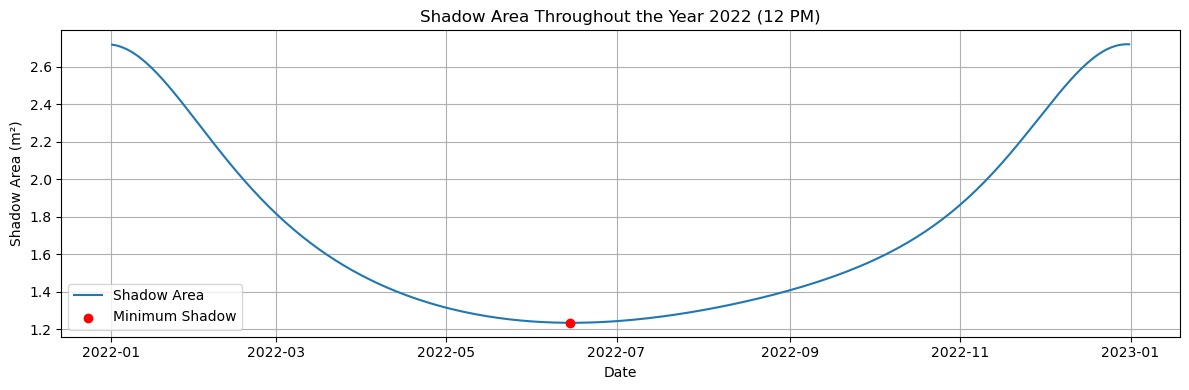

In [9]:
# 📌 10. Find the Date and Time of Minimum Shadow in 2022

from tqdm import tqdm

min_area = float('inf')
min_dt = None
shadow_data = []

print("Calculating minimum shadow over the year 2022...")

for month in range(1, 13):
    for day in range(1, 32):
        try:
            dt_local = TIMEZONE.localize(datetime(2022, month, day, 12, 0))  # Solar noon approximation
            area, _ = calculate_shadow_area(dt_local, sun_model="pvlib", visualize=False)
            if area > 0:
                shadow_data.append((dt_local, area))
                if area < min_area:
                    min_area = area
                    min_dt = dt_local
        except Exception:
            continue  # Skip invalid dates (e.g., Feb 30)

print(f"\n📅 Minimum shadow area in 2022 is {min_area:.4f} m²")
print(f"🕒 Occurs on: {min_dt.strftime('%Y-%m-%d %H:%M')} IST")

# Optional: Plot shadow area throughout the year
dates, areas = zip(*shadow_data)
plt.figure(figsize=(12, 4))
plt.plot(dates, areas, label="Shadow Area")
plt.scatter(min_dt, min_area, color='red', label="Minimum Shadow", zorder=5)
plt.title("Shadow Area Throughout the Year 2022 (12 PM)")
plt.xlabel("Date")
plt.ylabel("Shadow Area (m²)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()